# 8-1.프로젝트 : CIFAR-10 이미지 생성하기
---
* STEP 1. 작업환경 구성하기
* STEP 2. 데이터셋 구성하기
* STEP 3. 생성자 모델 구현하기
* STEP 4. 판별자 모델 구현하기
* STEP 5. 손실함수와 최적화 함수 구현하기
* STEP 6. 훈련과정 상세 기능 구현하기
* STEP 7. 학습 과정 진행하기
* STEP 8. (optional) GAN 훈련 과정 개선하기

GAN을 학습하는 과정은 보기보다 까다롭다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 보자.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있다.

* 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
* 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
* 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

In [82]:
# 주요 라이브러리 버전을 확인
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


In [83]:
import os # 파일 및 디렉터리 관리와 관련된 기능을 제공하는 os 모듈을 불러온다
import glob # 파일 경로를 패턴 매칭하여 검색하기 위한 glob 모듈을 불러온다
import time # 시간과 관련된 기능을 사용하기 위한 time 모듈을 불러온다

import PIL # Python Imaging Library로 이미지 처리와 관련된 기능을 제공
import imageio # 이미지 입출력을 위한 imageio 라이브러리를 불러온다
import numpy as np # 다차원 배열 및 행렬 연산을 위한 NumPy 라이브러리를 불러온다
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display # IPython에서 제공하는 display 모듈을 불러온다. 주로 Jupyter Notebook에서 시각화를 보여줄 때 사용
import matplotlib.pyplot as plt # 데이터 시각화를 위한 Matplotlib 라이브러리의 pyplot 모듈를 불러온다
%matplotlib inline 
# Jupyter Notebook에서 Matplotlib 그래프를 출력할 때 사용되는 매직 명령어로, 그래프를 인라인으로 표시하도록 지정한다

### STEP 1. 작업환경 구성하기

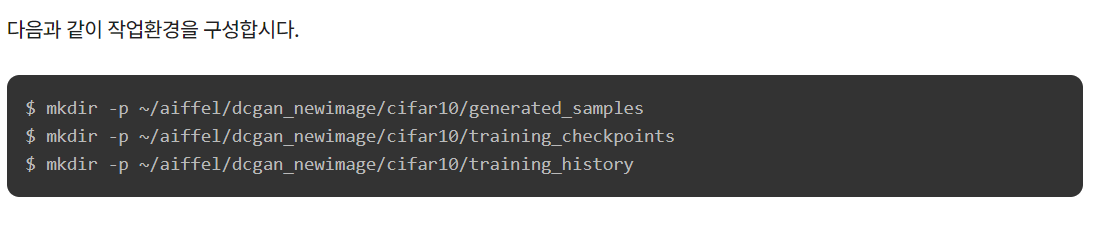

### STEP 2. 데이터셋 구성하기

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있다.

In [84]:
# 라벨은 제외하고 이미지 데이터만 할당
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [85]:
test_x.shape

(10000, 32, 32, 3)

* 각 픽셀은 0~255 사이의 정숫값을 가진다.

In [86]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


* 학습에 사용할 train_x의 이미지를 -1, 1로 정규화한다.

In [87]:
# train_x를 정규화
train_x = (train_x - 127.5)/127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [88]:
# 데이터셋의 shape
train_x.shape

(50000, 32, 32, 3)

In [89]:
train_x = train_x.astype('float32')
train_x.shape

(50000, 32, 32, 3)

#### astype('float32')를 해주는 이유

astype('float32')는 데이터 타입을 'float32'로 변환하는 메소드입니다. 이 코드에서 train_x 배열의 데이터 타입을 'float32'로 변환하는 이유는 주로 딥 러닝 모델의 입력 데이터로 활용하기 위함입니다.

딥 러닝에서는 일반적으로 입력 데이터를 정규화(normalization)하여 모델의 학습을 안정화시키는 것이 좋습니다. 'float32'는 32-bit 부동 소수점 형식으로, 정규화된 데이터를 저장하기에 적절한 형식 중 하나입니다. 이는 모델의 가중치를 업데이트할 때 발생하는 연산의 정확도를 유지하면서도 메모리를 효율적으로 사용할 수 있도록 도와줍니다.

또한, 딥 러닝에서는 주로 입력 데이터를 0과 1 사이의 값으로 정규화합니다. 'float32' 형식으로 변환하는 것은 이러한 정규화 작업에 적합한 데이터 타입을 사용하려는 의도를 나타냅니다. 일반적으로 이미지 데이터를 다룰 때는 0에서 255까지의 픽셀 값이 있으며, 이를 0과 1 사이로 정규화하기 위해 'float32' 형식으로 변환하는 것이 흔히 사용됩니다.

따라서 astype('float32')를 사용하여 데이터 타입을 변경하면, 데이터의 정확도를 유지하면서도 정규화와 같은 전처리 작업을 수행할 수 있습니다.

#### 부동 소수점

부동 소수점은 실수를 컴퓨터에서 표현하는 방법 중 하나입니다. 정확한 표현은 복잡하고 무한소수인 실수를 유한한 비트로 근사하여 표현하는 방식입니다. 컴퓨터에서는 부동 소수점 표현을 사용하여 실수를 다룹니다.

부동 소수점은 일반적으로 IEEE 754 표준에 따라 표현됩니다. 이 표준은 부동 소수점을 32비트 또는 64비트로 표현하는 방법을 정의하고 있습니다. 여기서는 주로 32비트 부동 소수점을 다루도록 하겠습니다.

32비트 부동 소수점 표현은 다음과 같이 구성됩니다:

부호 비트(Sign Bit): 1비트
지수 부분(Exponent): 8비트
가수 부분(Significand): 23비트
부호 비트는 양수인지 음수인지를 나타내며, 지수 부분은 지수를 나타내고 가수 부분은 소수점 이하의 가수를 나타냅니다. 이러한 표현 방식은 정수와 유리수 모두를 표현할 수 있으며, 일정 범위의 수를 표현할 때는 높은 정밀도를 제공합니다.

예를 들어, 32비트 부동 소수점에서 0.1을 표현하면 다음과 같습니다:

부호 비트: 0 (양수)
지수 부분: 01111011 (127 + 3)
가수 부분: 10011001100110011001101 (0.10000000000000000000000...)
이진수로 표현된 가수 부분의 값은 실제로 0.1에 매우 근접한 값이 됩니다. 하지만 이 값은 정확히 0.1이 아니며, 부동 소수점에서는 특정 소수를 정확하게 표현하기 어려운 한계가 있습니다.

* 로드한 학습 데이터를 시각화를 통해 확인해 보자.

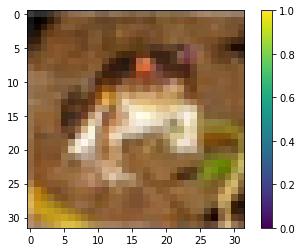

In [90]:
# 이미지 확인
tmp_train_x = (train_x+1)*0.5 # [0, 1] 범위로 train data 조절 - imshow 함수는 [0, 1] 범위의 값으로 정규화된 이미지를 기대하기 때문에
plt.imshow(tmp_train_x[0])
plt.colorbar()
plt.show()

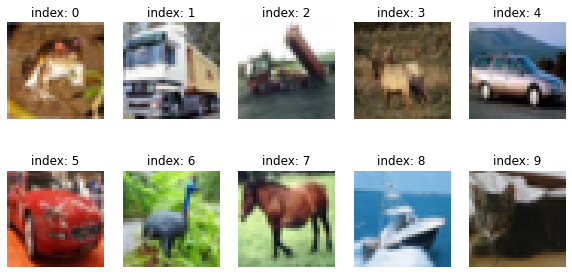

In [91]:
# for문을 활용하여 열 개 정도를 한 번에 띄워보자.

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(tmp_train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

**맨 첫 줄의 plt.figure(figsize=(10, 5))는 이미지의 전체 프레임의 크기를 결정한다.** 궁금하다면 한번 숫자를 바꿔서 실행시켜보자!

또한 여러 개의 이미지를 한 번에 띄우고 싶을 때에는 plt.subplot(row, col, index)의 형태로 볼 수 있다.
10개의 이미지를 2x5의 배열 형태로 보고 싶은 경우, plt.subplot(2, 5, index)로 작성하면 되는 것이다. index는 1부터 10까지 순서대로 바뀌어야 하니 for문에서 사용하는 i에 1을 i+1을 넣어주면 된다. (i는 range(10)으로 꺼냈으니 0~9의 숫자로 반복된다.)

추가적으로 plt.title('title') 함수를 이용해서 이미지에 제목으로 라벨 값을 넣어줬고, plt.axis('off') 함수로 불필요한 축을 지워서 깔끔하게 나타냈다.

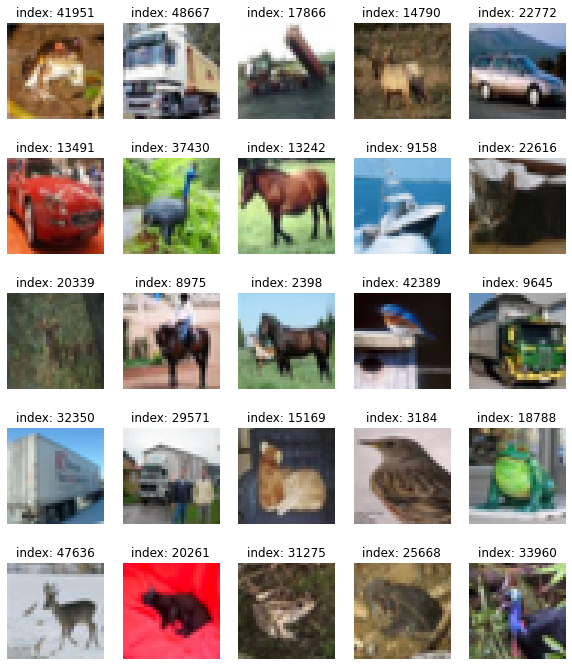

In [92]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    r = np.random.randint(1, 50000)
    plt.imshow(tmp_train_x[i])
    plt.title(f'index: {r}')
    plt.axis('off')

plt.show()

#### NumPy에서 랜덤으로 정수를 추출하는 함수 중 주로 사용되는 함수

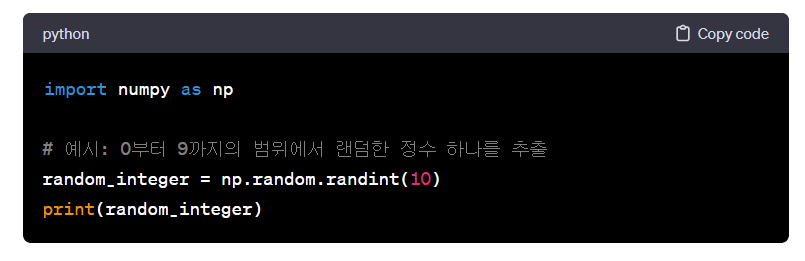

위 코드에서 np.random.randint(10)은 0부터 9까지의 정수 중 하나를 랜덤하게 추출합니다.

더 일반적인 형태로는 최소값(low)과 최대값(high)을 지정하여 범위를 설정할 수 있습니다. 예를 들어, 1부터 100까지의 범위에서 랜덤한 정수를 추출하려면 다음과 같이 사용할 수 있습니다:

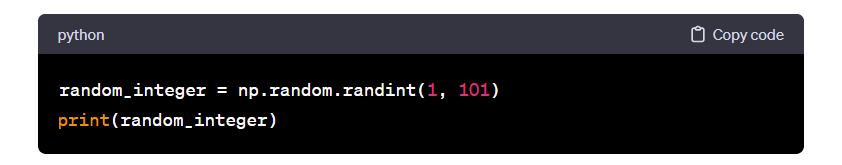

이렇게 하면 1 이상 100 이하의 정수 중 하나가 랜덤하게 선택됩니다. **high 파라미터는 범위에 포함되지 않으므로 주의해야 합니다.**

* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 보자

이제 데이터에 대한 전처리는 모두 마쳤다!

이렇게 정리된 데이터를 곧 모델에 넣어서 학습시켜야 하니, 편하게 사용할 수 있도록 텐서플로우의 Dataset을 이용해 준비해 놓도록 하자. 이를 이용하면 우리가 매번 모델에게 직접 섞어서 넣어주지 않아도 된다.

In [93]:
BUFFER_SIZE = 50000 # 이미지의 총 개수
BATCH_SIZE = 256

* BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정한다. shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것이다.

텐서플로우 공식 문서: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양이다.
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행한다. 이러한 방식을 미니 배치 학습이라고 한다.

In [94]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# tf.data.Dataset.from_tensor_slices(train_x): 주어진 train_x 배열을 기반으로 TensorFlow의 데이터셋 객체를 생성합니다. 
    # from_tensor_slices 함수는 주어진 텐서(또는 텐서 목록)에서 slices를 생성하여 데이터셋을 만듭니다.
#.shuffle(BUFFER_SIZE): 데이터셋을 섞는데 사용됩니다. BUFFER_SIZE는 섞을 때 사용하는 버퍼의 크기를 나타냅니다. 
    # 더 큰 버퍼 크기는 더 많은 데이터를 섞지만 더 많은 메모리를 사용합니다. 이후 배치 생성 시 섞인 데이터 중에서 일정 개수를 선택하게 됩니다.
# .batch(BATCH_SIZE): 데이터셋을 배치로 나눕니다. 
    # BATCH_SIZE는 각 배치에 포함될 샘플의 개수를 나타냅니다. 배치는 모델의 가중치 업데이트에 사용

**tf.data**

tf.data는 TensorFlow에서 데이터 입력 파이프라인을 구축하고 처리하기 위한 모듈입니다. 이 모듈은 데이터를 불러오고 전처리하며, 효율적으로 모델에 공급할 수 있는 기능을 제공합니다.

tf.data 모듈은 크게 두 가지 구성 요소로 나눌 수 있습니다:

tf.data.Dataset:

tf.data.Dataset은 데이터셋을 나타내는 추상적인 개념입니다. 여러 데이터 소스에서 데이터를 불러오거나 생성할 수 있습니다.
데이터를 전처리하고 변환하는 일련의 연산을 적용할 수 있습니다.
데이터셋을 반복(iterate)하면서 모델에 입력으로 제공할 수 있습니다.
tf.data.Iterator:

tf.data.Iterator는 데이터셋을 순회(iterate)하는 데 사용되는 인터페이스입니다.
tf.data.Dataset.make_one_shot_iterator()와 같은 메서드를 사용하여 데이터셋을 반복할 수 있는 이터레이터를 생성합니다.
get_next() 메서드를 사용하여 이터레이터로부터 다음 데이터를 가져옵니다.
tf.data는 데이터 입력 파이프라인을 효율적으로 구성하고, 병렬로 데이터를 읽어오며, 메모리를 효율적으로 사용하고자 하는 목적으로 도입되었습니다. 주로 대용량 데이터셋을 다루거나 GPU 학습 성능을 최적화할 때 활용됩니다.

-chatGPT-

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다. 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 한다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.

### GAN이란?

자, 이제 데이터가 준비되었으니 모델을 만들어 볼 차례입니다. 이번에 만들 모델은 어떻게 생겼을까요?

위에서 많은 생성 모델들이 무엇을 할 수 있는지 먼저 살펴보았죠. 하지만 그것들은 모두 꽤나 발전된 형태의 생성 모델링 기법들입니다. 우리는 이제 첫 번째 생성 모델을 만드는 것이니 간단한 것부터 시작해 보도록 하겠습니다.

가장 간단한 형태의 생성 모델 중 하나는 바로 GAN(Generative Adversarial Network)입니다. GAN은 2014년 Ian Goodfellow라는 연구자에 의해 처음 나온 네트워크로, 발표된 후 독특하면서도 직관적인 아이디어로 많은 인기를 얻었고 지금까지도 굉장히 많은 연구가 이루어지고 있는 모델입니다.

> GAN은 생성 모델 중 하나입니다!
> 

맨 처음 DeepComposer 영상에서도 설명했듯, GAN에는 두 가지 네트워크가 있습니다.

- `생성자(Generator)`는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해 냅니다. 즉, 무에서 유를 창조하는 것과 같은 역할을 합니다.
- `판별자(Discriminator)`는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real 인지, Fake 인지에 대한 판단 정도를 실숫값으로 출력합니다.

Ian Goodfellow가 GAN을 처음 발표했던 2014년의 논문에서는 이 두 네트워크를 다음과 같이 비유했습니다. 원문을 한번 읽어볼까요?

> "In the proposed adversarial nets framework, the generative model is pitted against an adversary: a discriminative model that learns to determine whether a sample is from the model distribution or the data distribution. The generative model can be thought of as analogous to a team of counterfeiters, trying to produce fake currency and use it without detection, while the discriminative model is analogous to the police, trying to detect the counterfeit currency. Competition in this game drives both teams to improve their methods until the counterfeits are indistiguishable from the genuine articles." (출처 : https://arxiv.org/pdf/1406.2661.pdf)
> 

> "제안된 적대적 신경망 프레임워크에서 생성 모델은 적대적인 모델과 대립됩니다. 적대적인 모델은 샘플이 모델 분포에서 왔는지 아니면 데이터 분포에서 왔는지를 판별하는 학습을 합니다. 생성 모델은 마치 위조 지폐를 만들어내고 감지되지 않고 사용하려는 위조사들의 팀에 비유될 수 있으며, 적대적인 모델은 마치 경찰에 비유되어 위조 지폐를 감지하려는 역할을 합니다. 이 게임에서의 경쟁은 두 팀 모두가 자신들의 방법을 향상시키게 만들어, 위조품이 진짜와 구별하기 어려울 정도로 만듭니다.”
> 

**Q. Generative Model과 Discriminative Model은 각각 무엇에 비유되었나요?**

: Generative Model : 위조지폐를 만들어내는 팀

Discriminative Model : 위조 지폐범을 잡아내는 경찰

**Q. 두 팀을 모두 성장하게 하는 요인은 무엇이며, 궁극적인 목표는 무엇이라고 했나요?**

: **위조지폐를 만들어내는 팀은 잡히지 않기 위해 더 진짜 같은 지폐를 만들려고 하며, 그것을 잡아내려는 경찰은 끊임없이 진짜 지폐와 위조지폐를 구분하려고 한다. 즉, 서로 간의 경쟁이 둘 모두를 성장하게 한다. 궁극적인 목표는 진짜 지폐와 구분될 수 없는 위조지폐를 만들어 내는 것이다.**

이렇게 서로 경쟁하듯 이루어진 모델의 구조 덕분에 이름에 "Adversarial(적대적인)"이 들어가게 된 것입니다.

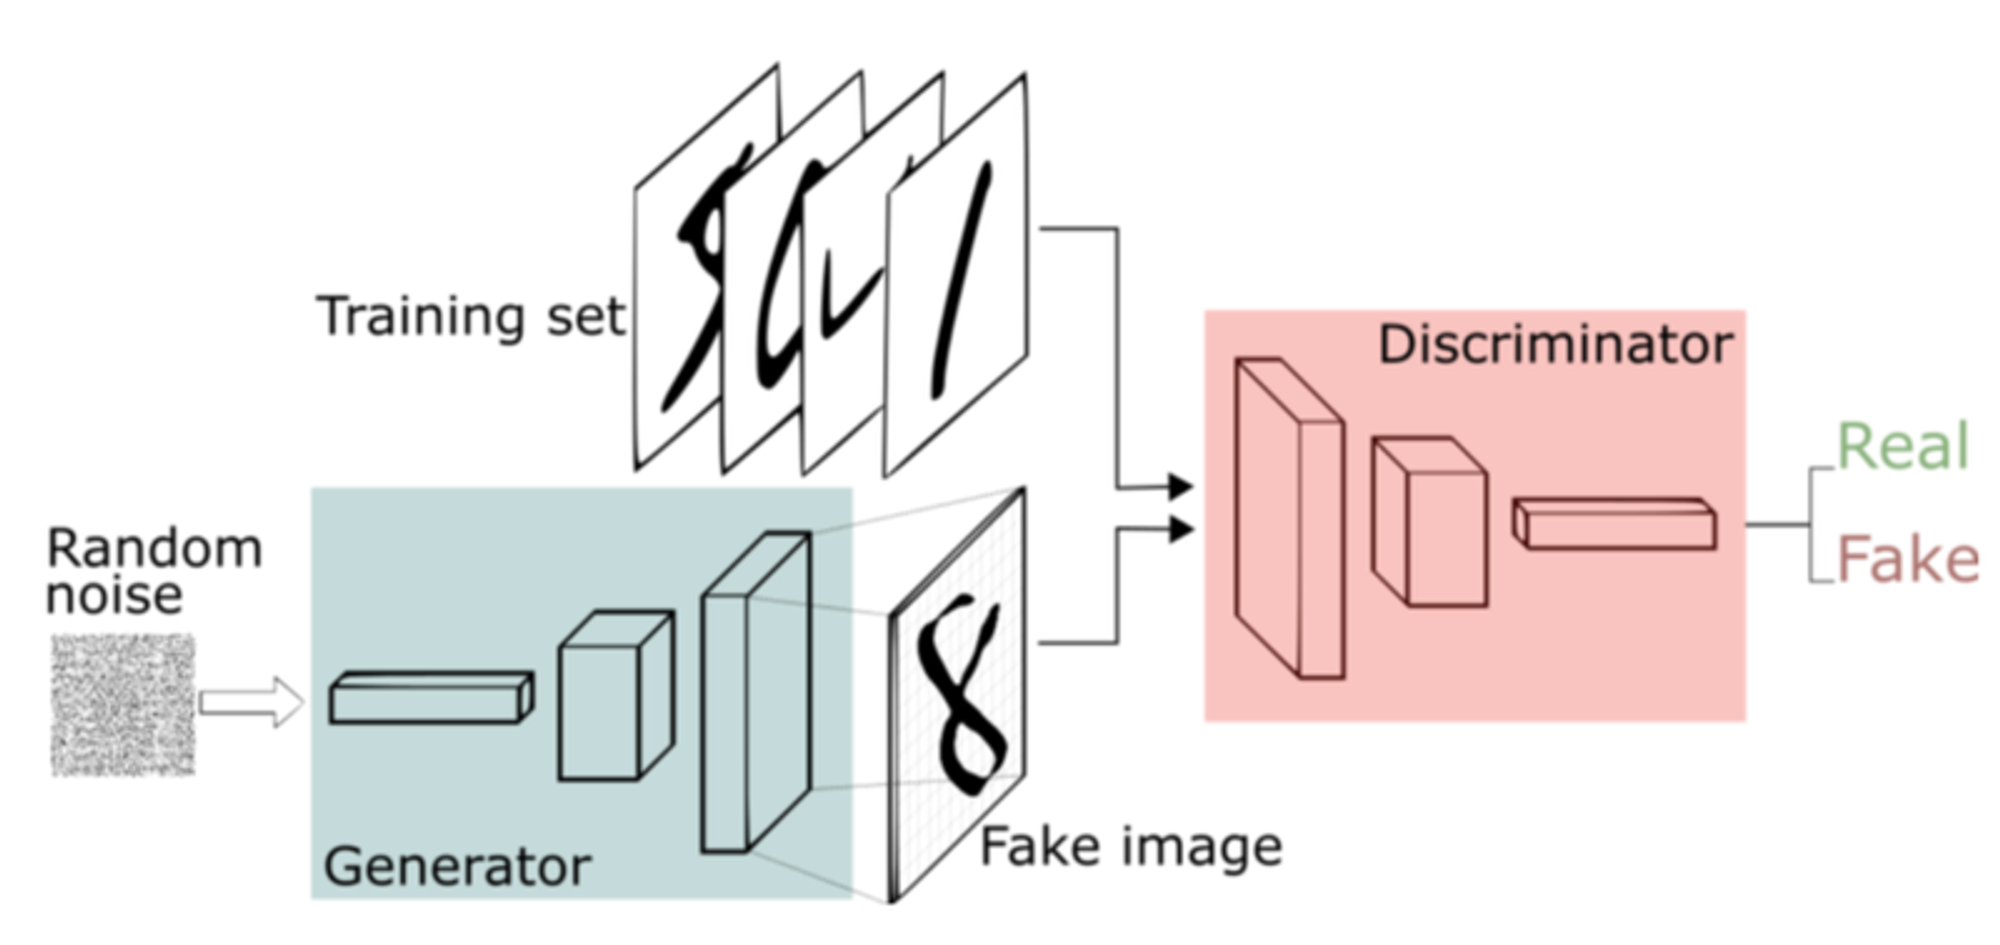

### GAN과 생성 모델 다시 정리하기

추가로 GAN에 대한 여러 가지 설명이 잘 나와 있는 2016년의 OpenAI 글을 한번 읽어봅시다.

전부 읽는 것은 어려울 수 있으니, 퀴즈의 답을 찾아보며 훑어보도록 하겠습니다!

**읽고 오기 : [Generative Models - openai](https://openai.com/blog/generative-models/)**

**Q. GAN 중 특히 합성곱 층(Convolutional Layer)으로 이루어진 딥러닝 모델을 DCGAN (Deep Convolutional GAN) 이라고 합니다. 본 글에서 설명한 DCGAN은 무엇을 입력받아 무엇을 출력하나요?**

: Input : 100 random numbers drawn from a uniform distribution (called as a code, or latent variables)Output : an image (in this case 64x64x3 images)

**Q. 글에서는 GAN을 포함해 총 세 가지의 생성 모델링 기법을 소개하였습니다. 나머지 두 가지는 무엇인가요?**

: Variational Autoencoders (VAEs)

Autoregressive models (ex. Pixel RNN)

### STEP 3. 생성자 모델 구현하기

* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 보자.

In [95]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential() # Sequential 모델 생성, 이 모델은 여러 층을 순차적으로 쌓은 모델을 나타낸다.

    # First: Dense layer
    # units은 8*8*256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,))) # 100차원의 랜덤한 잡음 벡터를 입력으로 받아, 
                                                                         # 7x7x256 크기의 텐서로 변환하는 완전 연결(Dense) 층을 추가
    # 배치 정규화 사용
    model.add(layers.BatchNormalization()) # 배치 정규화(Batch Normalization) 층을 추가하여 모델의 안정성을 높이고 훈련을 돕는다
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU()) # LeakyReLU는 음수 값에 대해 작은 기울기를 가지도록 하여, 그래디언트 소실 문제를 완화하는 역할

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256))) # 이전 층에서 생성된 벡터를 7x7x256 크기의 텐서로 변환

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # 이 층은 5x5 크기의 커널을 사용하여 텐서 크기를 확장
                                                                                                   # 스트라이드는 1로 설정하고, 패딩은 'same'으로 설정하여 출력 크기를 입력과 동일하게 유지
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # 더 큰 커널 크기와 스트라이드를 사용하여 텐서 크기를 다시 확장
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) # 출력 이미지를 생성하기 위해 5x5 크기의 커널을 사용하는 Conv2DTranspose 층을 추가
                                                         # 활성화 함수로는 tanh를 사용하여 -1에서 1 사이의 값으로 출력을 조정
                                                         # 3은 생성자가 출력하는 이미지의 채널 수를 의미(RGB -> 3)
    return model # 최종적으로 구성된 생성자 모델을 반환

# 이러한 생성자 모델은 GAN에서 사용되어 실제와 비슷한 가짜 이미지를 생성하는 역할을 한다.

* 우리가 사용하는 이미지에 맞게 8x8x256의 형태로 초기값을 입력

16,384개의 노드 중에서 하나의 노드에는 100차원의 입력 벡터가 들어갑니다. 이 100차원의 입력 벡터는 랜덤한 잡음 벡터로 시작하며, 생성자 모델의 목적은 이 랜덤한 잡음 벡터를 사용하여 실제와 유사한 가짜 이미지를 생성하는 것입니다.

따라서 생성자 모델의 첫 번째 Dense 레이어의 각 노드는 100차원의 잡음 벡터와 연결되어 있으며, 가중치를 사용하여 입력 벡터의 각 차원에 대한 정보를 학습합니다. 이렇게 학습된 가중치에 따라 각 노드는 특정한 특징이나 패턴을 학습하게 됩니다. 전체 Dense 레이어는 입력된 잡음 벡터를 8x8x256 크기의 텐서로 변환하는 역할을 수행합니다.

---

make_generator_model이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 했다.

함수 내부에서는 먼저 tf.keras.Sequential()로 모델을 시작한 후 레이어를 차곡차곡 쌓아준다.

여기에서 가장 중요한 레이어는 바로 Conv2DTranspose 레이어이다. Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다. 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나간다. **여기서 최종 사이즈인 (28, 28, 1)은 우리가 준비했던 데이터셋과 형상이 동일하다.**

* [What is Transposed Convolutional Layer?](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11)

레이어의 사이사이에 특정 층들이 반복되는 것을 확인할 수 있는데, BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜준다. 또한 중간층들의 활성화 함수는 모두 LeakyReLU를 사용하였다. 다만 마지막 층에는 활성화 함수로 tanh를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함이다.


* [Batch Normalization](https://eehoeskrap.tistory.com/430)
* [활성화 함수 (activation function)](https://newly0513.tistory.com/20)

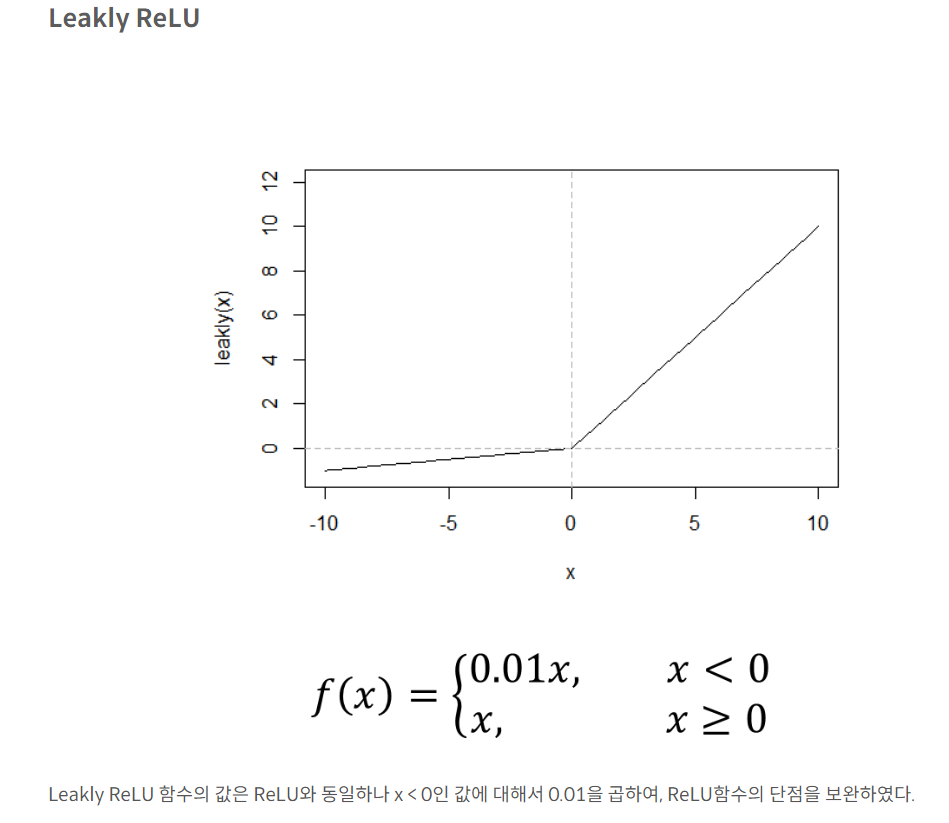

**Q. 생성자의 입력 벡터는 어떤 형태입니까?**

: 모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받습니다.

**Q. 처음 입력된 벡터는 어떤 레이어를 지나며, 첫 레이어를 지난 후의 shape는 어떤 형태입니까?**

: 입력된 (batch_size, 100) 벡터는 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 됩니다.

**Q. 첫 번째 레이어를 지난 후 벡터는 어떤 층을 지나게 됩니까? 이 레이어는 왜 필요합니까?**

: 첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지나게 됩니다.
이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업입니다.


In [96]:
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)        

* 최종 출력 값이 (32, 32, 3)의 형태를 가진다.

* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 보자.

그럼 모델이 만들어졌으니, shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 보도록 하자.

아직 모델이 학습되지 않았으니, 아마 결과물도 큰 의미가 있지는 않을 것이다.

tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.

In [97]:
# TensorFlow에서 제공하는 tf.random.normal 함수를 사용하여 형상이 [1, 100]인 랜덤한 노이즈 벡터를 생성
noise = tf.random.normal([1, 100]) # tf.random.normal([1, 100]) 코드는 1차원 벡터의 형상을 가지며, 
                                   # 이 벡터의 각 원소를 평균이 0이고 표준 편차가 1인 표준 정규 분포에서 생성한 난수로 채운다

텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성된다 (내부적으로는 생성자의 call 함수가 호출된다).

단, 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 한다! Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있다.

In [98]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

[1, 32, 32, 3] 사이즈의 이미지가 잘 생성되었다!
첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가진다.

그러면 이 이미지를 또 시각화해서 봐야겠다.
matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 한다.

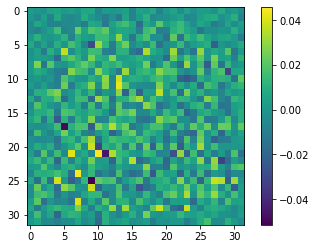

In [99]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

-1과 1 사이의 값에서 적당히 잘 생성된 것을 확인할 수 있다.
아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성되었지만, 모델이 점차 학습해 나가며 제대로 된 이미지를 생성하기를 바라보자!

> plt.imshow(generated_image[0, :, :, 0]) 코드는 생성된 이미지의 첫 번째 채널을 시각화하고 있습니다. 일반적으로 GAN에서 생성된 이미지의 각 픽셀 값은 -1에서 1 사이의 값으로 조정됩니다. 이는 생성자 모델의 마지막 레이어에서 tanh 활성화 함수를 사용하여 출력을 조정한 결과입니다.
>

### STEP 4. 판별자 모델 구현하기

* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 보자.

그러면 이제 판별자를 설계할 시간이다!

판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 한다.
그렇다면 입력은 (28, 28, 1) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것이다.

In [100]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3])) # 이미지 사이즈에 맞춰서 input_shape를 맞춰준다.
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

판별자 또한 make_discriminator_model 함수로 구현하였다.

Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나간다.
첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 된다.

마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환합니다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 한다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 된다.

그럼 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력해 보자.

In [101]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

* 아까 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올까? 확인해 보자.

In [102]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00211035]], dtype=float32)>

><tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00204971]], dtype=float32)>에서 shape=(1, 1)은 해당 텐서의 형상(shape)을 나타냅니다. 이 경우, 형상은 1차원으로서 1개의 원소만을 가지는 벡터입니다. 각 차원의 크기가 1이므로 1차원 텐서입니다.

>두 번째 1은 벡터 안에 있는 원소의 개수를 나타냅니다. 따라서 이 텐서는 1차원 벡터이며, 1개의 원소를 가지고 있습니다. 이것은 주로 이진 분류(Binary Classification)에서 사용되는 판별자(Discriminator)의 출력 형태로 해석됩니다. 하나의 숫자로 나타내어진 판별자의 출력은 보통 어떤 입력이 진짜 데이터에 가까운지를 나타내는 점수(확률이 아닌)로 이해될 수 있습니다.

>따라서 decision 텐서의 형상은 (1, 1)이며, 이는 하나의 숫자로 이루어진 1차원 벡터임을 나타냅니다.

텐서플로우의 텐서 형태로 출력이 되었다. 이 값 또한 아직은 아무런 의미가 없는 값일 것이다.

그렇다면 이제 드디어 모델 학습을 위한 여정을 떠나보자!

### STEP 5. 손실함수와 최적화 함수 구현하기

이제 생성자와 판별자 두 가지 네트워크가 모두 준비되었으니 모델을 학습시키는 일만 남았다.
생성자가 판별자를 속이기 위해 학습해 나가면서 결국 잘 학습되면 어떤 새로운 패션을 만들어낼지 너무 궁금하지 않나?!

자, 그러면 모델 학습을 위한 재료를 준비해 보자.
딥러닝 모델이 학습하기 위해서 꼭 필요한 두 가지는, 바로 손실함수(loss function)와 최적화 함수(optimizer)이다.

#### 손실함수(loss function)
---
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.
교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이다. 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰인다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것이다.

자, 이쯤에서 다시 생성자와 판별자의 목적이 무엇이었는지 한번 정리해 볼까? 생성자는 자기가 생성한 Fake Image를 판별자가 진짜라고 판단하도록 속이고 싶어 한다. 판별자는 생성자가 생성한 가짜 이미지를 가짜로, 진짜 이미지를 진짜로 잘 판별하는 것이 목표이다.

그렇다면 Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같겠다.

* 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
* 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되겠다! 이러한 기준을 가지고 생성자, 판별자 각각에 대한 손실함수를 설계해 보자.

손실함수에 사용할 교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있다.

다만, 우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있다.

그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정한다 [(참고)](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy#args_1). **따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다.**

In [103]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

그럼, 이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용한다.

* fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
* real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

그럼 이제, fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까?

바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 된다.

이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용한다.
어떤 식으로 활용되는지, 한번 실험해 보자.

In [104]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

* 입력해 준 vector와 형태는 같지만, 그 내용물은 모두 1인 벡터가 만들어졌다. 간단히 원하는 영벡터 또는 1로 채워진 벡터를 만들어낼 수 있는 것이다.

#### generator_loss

그러면 generator_loss는 다음과 같이 구현할 수 있겠다.

generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 된다.
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.

In [105]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### discriminator_loss

반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산한다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 된다!

최종 discriminator_loss 값은 이 둘을 더한 값이다.

In [106]:
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

#### discriminator accuracy

한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용하다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까? 그렇지 않다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻이다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.

In [107]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같다.

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
* > tf.Tensor([False, False, True, True])

(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
* > tf.Tensor([0.0, 0.0, 1.0, 1.0])

(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
* > 0.5

### 최적화 함수(optimizer)
---
그럼 손실함수는 모두 설계가 되었고, 이제 최적화 함수를 설정할 차례이다. 이번에는 Adam 최적화 기법 을 활용해 보겠다.

* [문과생도 이해하는 딥러닝 (8) - 신경망 학습 최적화](https://sacko.tistory.com/42)

Adam 함수 또한 tf.keras.optimizers 안에 있다.
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천한다.

또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점이다.

In [108]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # 1e-4: 10의 -4승 = 0.0001
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것이다.

샘플은 한 번에 16장을 생성하도록 하겠다.

생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 한다.

즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠다.

In [109]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 보자.

그렇다면 이제 진짜 훈련을 위한 코드를 만들어 보도록 하자.

하나의 미니 배치 당 진행할 train_step 함수를 먼저 만들어야 한다.

텐서플로우 2.0 이후부터는 1.x의 이전 버전과 다르게, session을 사용하지 않는다. 대신, 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용한다. 이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해준다.

* [python decorator (데코레이터) 어렵지 않아요](https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/)

데코레이터의 개념은 어렵지 않더라도 @tf.function 이 정확히 어떤 역할을 해주는 것인지 명확히 이해가 안 되실 수도 있을 것 같다. Tensorflow Tutorial에는 이 데코레이터의 역할을 다음과 같이 정의하고 있다.

> tf.function : Compiles a function into a callable TensorFlow graph

아래 두 코드를 실행해 보면 위 정의의 의미가 명확해질 것이다.

In [110]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [111]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

* Numpy array 입력 x, y를 동일하게 사용했지만 f(x,y)의 결과 타입은 다르다. @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환된다. 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것 같다.

In [112]:
@tf.function # TensorFlow의 tf.function 데코레이터를 사용하여 이 함수를 TensorFlow 그래프로 컴파일한다. 이렇게 하면 성능 향상이 기대된다.
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
                                                                         # 두 개의 tf.GradientTape 컨텍스트를 연다. 
                                                                         # 이는 생성자와 판별자의 각각의 파라미터에 대한 그래디언트를 계산하기 위함
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산 - 판별자의 실제 이미지와 가짜 이미지에 대한 정확도를 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # generator.trainable_variables는 생성자 모델의 학습 가능한 변수(가중치 및 편향)들을 나타내는 TensorFlow 변수들의 리스트 
                                                                                        # 학습 가능한 변수들은 모델이 학습 중에 업데이트되는 매개변수들을 의미
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습 - 계산된 그래디언트를 사용하여 생성자와 판별자를 업데이트
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같다.

* (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
* (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
* (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
* (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
* (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
* (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
* (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
* (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
* (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
* (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 된다.

그러면, 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 보자.
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다.

In [113]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        generated_image = (predictions[i, :, :, :] + 1) / 2.0  # 픽셀 값 범위를 [0, 1]로 조정
        plt.imshow(generated_image)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sampleepoch{:04d}iter{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화해주는 과정이 담겨 있는데, 어딘가 익숙하다.

바로 우리가 위에서 해봤던, subplot을 이용해서 총 16개의 sample을 시각화하는 과정입니다. 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화하는 것이다.

또한, plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장한다.

학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없다. GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문이다. train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 보자. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정이다.

In [114]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어준다.

tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다. 모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적이다. 아주 오랜 시간 동안 학습을 시켰는데 네트워크가 끊긴다거나, 예상치 못한 문제로 인해 모델을 잃어버린다면 그보다 끔찍한 일은 없을 것이다.

checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장한다. 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장하는 것이다. 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둔다.

checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용하겠다.

In [115]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

* 이후 학습 중간에 모델의 상태를 저장하거나 복원하고 싶을 때, checkpoint.save(file_prefix=checkpoint_prefix)를 호출하여 체크포인트를 저장하거나, checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))를 호출하여 가장 최근의 체크포인트로부터 모델의 상태를 복원할 수 있습니다.

### STEP 7. 학습 과정 진행하기

* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 보자.
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 보자.
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출한다.

In [116]:
def train(dataset, epochs, save_every): # save_every - 일정 주기로 체크포인트롤 저장할 인자
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]} # history 딕셔너리는 학습 중에 발생한 생성자 손실, 판별자 손실, 
                                                                                      # 그리고 실제와 가짜 이미지에 대한 정확도를 기록하는 용도로 사용

    for epoch in range(epochs): # for 루프를 사용하여 에폭과 이터레이션을 순회하면서 모델을 학습
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch) 
            history['gen_loss'].append(gen_loss) # train_step 함수를 호출하여 각 배치에 대한 학습을 진행하고, 손실 및 정확도를 history에 기록
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0: # 매 50번째 이터레이션마다 생성된 이미지를 시각화하고 현재 학습 진행 상황을 출력
                display.clear_output(wait=True) # 출력된 이미지 등을 화면에서 지우고 새로운 이미지를 표시하기 위해 화면을 깨끗하게 지움
                generate_and_save_images(generator, epoch+1, it+1, seed) # 현재 에폭(epoch+1), 현재 이터레이션(it+1), 그리고 랜덤 시드(seed)를 전달
                print('Epoch {} | iter {}'.format(epoch+1, it+1)) # 현재 에폭과 이터레이션 정보를 출력
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start))) # 현재 에폭이 진행된 시간(경과 시간)을 계산하고 출력

        if (epoch + 1) % save_every == 0: # 일정 주기(save_every)마다 체크포인트를 저장, - 현재 에폭이 일정 주기(save_every)의 배수일 때마다 아래의 블록을 실행
                                          # 이는 학습 중에 중단되더라도 마지막 체크포인트부터 다시 학습을 시작할 수 있게 해줌
            checkpoint.save(file_prefix=checkpoint_prefix) # file_prefix 매개변수는 체크포인트 파일의 접두어를 지정합니다. 
                                                           # 이를 통해 나중에 해당 체크포인트를 불러올 때 사용

        display.clear_output(wait=True) # 각 에폭이 끝날 때마다 현재까지의 학습 결과를 시각화하고, 학습에 소요된 전체 시간을 출력
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch) # draw_train_history 함수를 호출하여 학습 중에 기록된 손실 및 정확도의 변화를 그래프로 그린다. 
                                           # 이는 학습이 어떻게 진행되었는지를 시각적으로 확인하는 데 도움이 된다.

**이터레이션**

"이터레이션하면서"는 데이터셋에서 배치(batch) 단위로 데이터를 추출하여 모델을 학습하는 과정을 의미합니다.

여기서 "이터레이션(iteration)"은 주어진 데이터셋을 한 번 훑는 과정을 나타냅니다. 각 이터레이션은 데이터셋에서 배치 크기만큼의 데이터를 추출하여 모델을 학습하는 과정을 말합니다.

이터레이션 루프는 for it, image_batch in enumerate(dataset):와 같이 구현됩니다. 이 구문은 주어진 데이터셋(dataset)에서 이터레이션을 수행하면서 각 이터레이션에서 현재 배치의 이미지 데이터를 image_batch로 받아오게 됩니다.

간단한 예시를 들어보겠습니다. 예를 들어, 데이터셋이 1000개의 이미지로 구성되어 있고 배치 크기가 32이면, 총 1000/32 = 31.25 번의 이터레이션이 필요합니다. 첫 번째 이터레이션에서는 1번부터 32번까지의 이미지를, 두 번째 이터레이션에서는 33번부터 64번까지의 이미지를 선택하여 모델을 학습하게 됩니다. 이러한 과정을 총 31번 반복하면 데이터셋 전체를 한 번 훑는 것이 되며, 이 과정이 한 번의 에폭(epoch)에 해당합니다.

여기서부터는 정말 별로 특별한 것이 없다. 우리가 생성된 샘플을 시각화하거나 원하는 시간을 출력하는 것뿐이기 때문이다.
출력하고자 하는 print문과 몇 번마다 출력하는지에 대한 구문을 원하는 대로 수정해서 마음에 드는 형태로 확인해 보자!

그러면 모델을 저장하는 간격을 담당하는 save_every와 전체 학습 에포크를 결정하는 EPOCHS 파라미터도 설정해 준 후 훈련시켜 보도록 하자!

본 학습은 이미지를 활용한 것이기 때문에 CPU 환경에서는 매우 느릴 수 있다.
RTX2070 또는 구글 Colab의 T4 정도 사양의 경우 1 Epoch 당 10초가 걸리는 반면, 일반적인 CPU 환경에서는 최소 3분에서 10분 이상이 걸릴 수 있으므로 최대한 GPU 환경에서 실습해 보는 것을 추천한다.

이제 다음과 같이 train() 함수를 실행시키면 드디어 모델이 학습해 나가면서 만들어내는 결과물을 실시간으로 확인할 수 있다!

In [117]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### GAN 학습을 진행

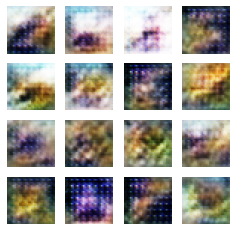

Time for training : 865 sec


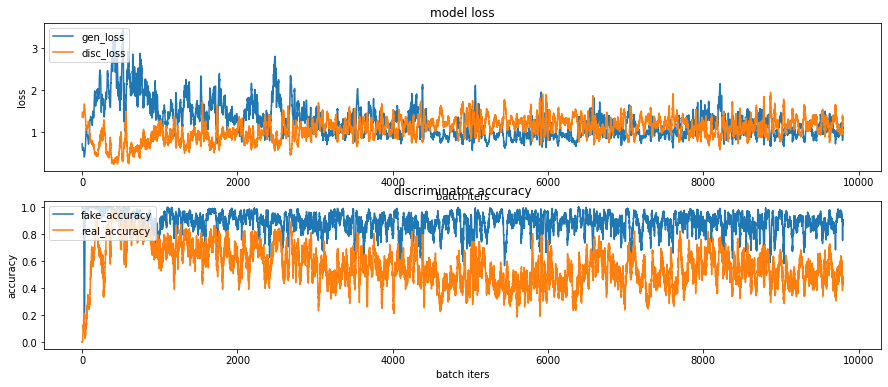

CPU times: user 14min 46s, sys: 1min 3s, total: 15min 50s
Wall time: 14min 26s


In [118]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

* 이미지가 상당히 불분명한 것을 볼 수 있다.
* gen_loss와 disc_loss가 약 3500 batch iters부터 중간에서 서로 경합을 하는 것을 보아, loss는 나쁘지 않은 것 같다.
* real_accuracy는 계속 감소하고, fake_accuracy가 1.0에 계속 가까운 것을 볼 수 있다. 따라서 둘다 0.5에 가까워지지 않는 것을 보아, 이상적인 학습이 진행되고 있지 않을 것을 알 수 있다.

### 회고문

GAN 모델 구조 자체는 뭔가 색다르고 흥미로워서, 진행하는 동안 재미있었던 것 같다. 다만, 아직 전반적인 코드 이해는 여전히 어려운 것 같다. 이미지 생성되면서 계속 개선되는 이미지를 실시간으로 확인할 수 있는 것도 흥미로웠다. checkpoint는 딥러닝을 진행하는 데 있어서 꼭 필요한 수단이지만, 아직 어떻게 사용해야 하는지 이해가 잘 안 가는 것 같다. 좀 더 활용할 수 있게 구글링해봐야겠다. 또 민규님이 알려주신 유튜브 영상을 보고 생성형 모델에 대해서 좀 더 이해해 보면 좋을 것 같다.

#### KEEP
: 코드를 전반적으로 이해하려고 구글링을 해보고, chatGPT를 활용한 점, 노드 학습을 진행할 때,  다음에 볼 때 편하도록 노트북에 내용을 잘 정리해둔 것

#### PROBLEM
: 코드가 아직 어렵다, 그래프 해석에 대한 이해도가 아직 떨어진다.

#### TRY
: 생성형 모델에 대해서 좀 더 서치해보기, 민규님이 알려주신 유튜브 영상 보기

